# Explore GMM Results
This notebook allows for the exploration of Gaussian Mixture Model based geoinferencing. It uses test messages and a pretrained model to begin to explore why the answer is what it is. 

In [1]:
from src.algorithms.gmm import GMM
from src.utils.geo import haversine
import numpy as np
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
# Import GMM Model Code
from src.algorithms.gmm import GMM
import math
# Make our plots default to larger
plt.rcParams['figure.figsize'] = (12.0, 10.0)

### Load a pretrained GMM Model and import training data ('data_path')

In [2]:
# Load test data
temp_table_name = 'tweets'
test_data_path = 'hdfs:///path/to/test/data/*'

In [3]:
g = GMM(sc, sqlCtx, {'fields':set(['user.location', 'text']), 'json_path':'/local/path/to/twitter_format.json'})
# Train Model [This takes a while so make sure to save it]
#g.train('hdfs:///path/to/training/data')
#g.save('/local/path/to/pretrained_model.pkl')

# Load pretrained model
g.load('/local/path/to/pretrained_model.pkl')

### Evaluate the performance of this model on a set of test data

In [29]:
g.test(test_data_path)

('Median Error', 355.51098913181306)
('Mean Error: ', 2487.322977111829)


{'coverage': 0.9331837286883633,
 'data_path': 'hdfs:///path/to/twitter/data',
 'mean': 2487.322977111829,
 'median': 355.51098913181306,
 'options': {'fields': {'text', 'user.location'}}}

### Pull a set of test data to use for interactive exploration

In [ ]:
# Create a temporary table in this context which allows us to explore interatively
all_tweets = sqlCtx.parquetFile(test_data_path)
all_tweets.cache()
all_tweets.registerTempTable(temp_table_name)

In [28]:
# NOTE: This where clause filters out US geo coorindates 
#where_clause = "lang = 'en' and geo.coordinates is not null and user.location is not null"
where_clause = "geo.coordinates is not null and user.location is not null"
limit = 10000
sql_stmt = 'select * from %s where %s limit %d'%(temp_table_name, where_clause, limit)
print 'Query Executed:', sql_stmt

Query Executed: select * from tweets_may_yonas where geo.coordinates is not null and user.location is not null limit 10000


In [29]:
# Peform query and pull to local context
# TODO: Consider switching to sampling
local_tweets = sqlCtx.sql(sql_stmt).collect()
print 'Pulled %d tweets into local context'%len(local_tweets)

Pulled 10000 tweets into local context


## Helper functions

In [6]:
def print_tweet(tweet):
    print
    print 'Text:', tweet.text
    print 'User Specified Location:', tweet.user.location
    print 'Location:', tweet.geo.coordinates

In [7]:
# Temporary block of code until the new gmm models are run
####TODO REMOVE THIS when Re-Run!!!!!!!
from sklearn import mixture

def combine_gmms(gmms):
    """ Takes an array of gaussian mixture models and produces a GMM that is the weighted sum of the models"""
    n_components = sum([g[0].n_components for g in gmms])
    covariance_type = gmms[0][0].covariance_type
    new_gmm = mixture.GMM(n_components=n_components, covariance_type=covariance_type)
    new_gmm.means_ = np.concatenate([g[0].means_ for g in gmms])
    new_gmm.covars_ = np.concatenate([g[0].covars_ for g in gmms])
    weights = np.concatenate([g[0].weights_ * ((1/g[1])**4) for g in gmms])
    new_gmm.weights_ = weights / np.sum(weights) # Normalize weights
    new_gmm.converged_ = True
    return new_gmm

In [8]:
def get_gmm_info(inputRow):
    (location, tokens) = GMM.tokenize(inputRow, fields=g.options['fields'])
    true_lat, true_lon = location
    models = []
    for token in tokens:
        if token in g.model:
            models.append(g.model[token])
    #min_error = None
    errors = [m[1] for m in models]
    if len(errors) > 0:
        min_error = min(errors)
    else:
        min_error = None
        
    if len(models) > 1:
        combined_gmm = combine_gmms(models)
    elif len(models) == 1:
        combined_gmm = models[0][0]
    else:
        np.nan
        #return (None, np.nan, np.nan, None)
    (best_lat, best_lon) = combined_gmm.means_[np.argmax(combined_gmm.weights_)]
    distance = haversine(best_lon, best_lat, true_lon, true_lat)
    return ((best_lat, best_lon), min_error, distance, combined_gmm)

In [9]:
def plot_gmm(gmm_model, true_ll=None, percent=None):
    plt.figure()
    y = np.linspace(90,-90, num=180)
    x = np.linspace(-180,180, num=360)
    X, Y = np.meshgrid(y,x)
    XX = np.array([X.ravel(), Y.ravel()]).T
    #Z = np.log(-gmm_model.score_samples(XX)[0]+1)
    Z = -gmm_model.score_samples(XX)[0]
    
    if percent:
        Z = np.exp2(gmm_model.score_samples(XX)[0]) 
        target = np.sum(Z)*percent
        z_sorted = sorted(Z, reverse=True)
        i = 0
        sum = 0
        while sum < target:
            sum += z_sorted[i]
            i += 1
        print 'Percent of the world:', float(XX[Z > z_sorted[i]].shape[0])/XX.shape[0]*100
        Z[Z < z_sorted[i]]  = 0
        Z = -np.log(Z)
        #Z = Z.reshape(X.shape)
    
    Z = Z.reshape(X.shape)

    m = Basemap(projection='mill', lon_0=0)#,lon_0=0.5*(lons[0]+lons[-1]))

    m.drawcountries()
    m.drawcoastlines()
    m.drawparallels(np.arange(-90.,120.,30.),labels=[1,0,0,0]) # draw parallels
    m.drawmeridians(np.arange(0.,420.,60.),labels=[0,0,0,1]) # draw meridians
    #m.drawcounties()

    #cmap = mpl.cm.RdYlBu
    cmap = mpl.cm.pink
    norm = mpl.colors.Normalize(vmin=0, vmax = 5)

    X, Y = m(Y,X)
    CS = m.contourf(X, Y, Z, 25,linewidths=1.5, cmap=cmap)#, norm=norm)
    #CS = plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),
    #                 levels=np.logspace(0, 3, 20))
    CB = plt.colorbar(CS, shrink=0.8, extend='both')
    
    # Plot estimated location
    (best_lat, best_lon) = gmm_model.means_[np.argmax(gmm_model.weights_)]
    best_lat, best_lon = m(best_lon, best_lat) 
    plt.plot(best_lat, best_lon, '*g')
    
    if true_ll:
        lat, lon = m(true_ll[1], true_ll[0])
        plt.plot(lat, lon, '*b')
        
    #lon, lat = gmm_model.means_[i]
    for i in range (0, gmm_model.n_components):
        lat, lon = gmm_model.means_[i]
        weight = gmm_model.weights_[i]
        x, y = m(lon, lat)
        #plt.plot(x, y, 'or')#, markersize=6*weight)
    plt.show()

In [10]:
def plot_gmm_w_percentage(gmm_model, percent):
    y = np.linspace(90,-90, num=180)
    x = np.linspace(-180,180, num=360)
    X, Y = np.meshgrid(y,x)
    XX = np.array([X.ravel(), Y.ravel()]).T
    Z = np.exp(gmm_model.score_samples(XX)[0]) 
    target = np.sum(Z)*percent
    z_sorted = sorted(Z, reverse=True)
    i = 0
    sum = 0
    while sum < target:
        sum += z_sorted[i]
        i += 1
    print 'Percent of the world:', float(XX[Z > z_sorted[i]].shape[0])/XX.shape[0]*100
    Z[Z < z_sorted[i]]  = 0
    Z = -np.log(Z)
    Z = Z.reshape(X.shape)
    m = Basemap(projection='mill', lon_0=0)#,lon_0=0.5*(lons[0]+lons[-1]))

    m.drawcountries()
    m.drawcoastlines()
    m.drawparallels(np.arange(-90.,120.,30.),labels=[1,0,0,0]) # draw parallels
    m.drawmeridians(np.arange(0.,420.,60.),labels=[0,0,0,1]) # draw meridians
    #m.drawcounties()

    #cmap = mpl.cm.RdYlBu
    cmap = mpl.cm.pink
    norm = mpl.colors.Normalize(vmin=0, vmax = 5)

    X, Y = m(Y,X)
    CS = m.contourf(X, Y, Z, 25,linewidths=1.5, cmap=cmap)#, norm=norm)
    #CS = plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),
    #                 levels=np.logspace(0, 3, 20))
    CB = plt.colorbar(CS, shrink=0.8, extend='both')
    plt.show()

In [ ]:
# Created a combined GMM for a tweet, score GMM performance and create a contour plot
def plot_row(inputRow):        
    (est_location, min_error, error_distance, combined_gmm) = get_gmm_info(inputRow)
    print_tweet(inputRow)
    print 'Estimated Location:', est_location
    print 'Error (km):', error_distance
    plot_gmm(combined_gmm, true_ll=inputRow.geo.coordinates)

## Look at probability distribution of a few tweets


Text: @LenaMotamed Je peux te draguer même si t'es en Normandie?
User Specified Location: Calais
Location: [50.946353, 1.85826]
Estimated Location: (49.215443858575213, 2.4839370881151814)
Error (km): 197.452261085


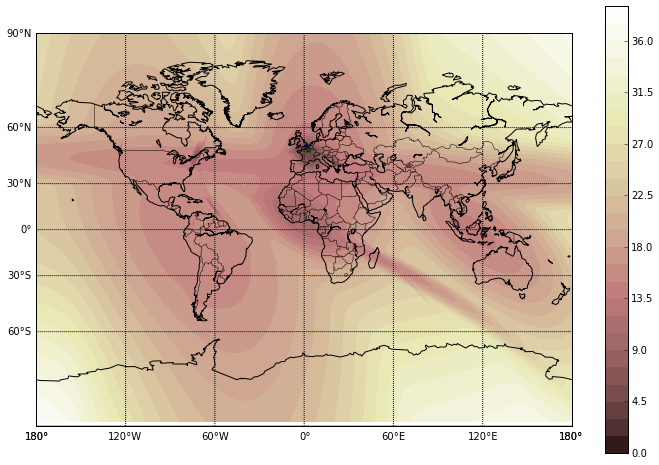

In [15]:
plot_row(local_tweets[0])


Text: Kisses Shanghai 😘😘😘 see you later @ Flair Rooftop Bar at The Ritz-Carlton Shanghai Pudong https://t.co/Dum6chie3U
User Specified Location: Toronto, Canada
Location: [31.238682, 121.496729]
Estimated Location: (31.215755473150573, 121.44900731439573)
Error (km): 5.20142928454


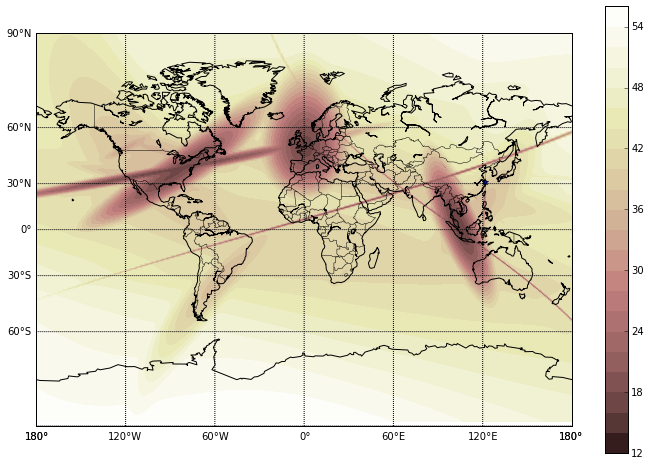

In [56]:
plot_row(local_tweets[6])

In [ ]:
# Print all the tweets we've pulled into the local context
for i, t in enumerate(local_tweets):
    print i, t.text

In [37]:
# Compute local array of actual error and min training error
min_errors = []
actual_errors = []
skipped = 0
for i in range(len(local_tweets)):
    try:
        (est_location, min_error, error_distance, combined_gmm) = get_gmm_info(local_tweets[i])
        if min_error != 0 and error_distance !=0:
            min_errors.append(min_error)
            actual_errors.append(error_distance)
    except:
        skipped += 1
print 'Skipped %d of %d'%(skipped, len(local_tweets))

Skipped 52 of 6416


## Compare prediction error [measured] to error in training data
X-axis [km]: The error of the word with the minimum error in the training set. Error in the training set is defined as the median distance between the most likely point and every occurrence of that word in the training data
Y-axis [km]: The distance between the most likely point and the actual point
The second plot is a log-log plot with the same axes

(0.35371615089002267, 9.3584132403879912e-187)
(0.84709657049658937, 0.0)


[0, 8.0063675676502459, 0, 8.0063675676502459]

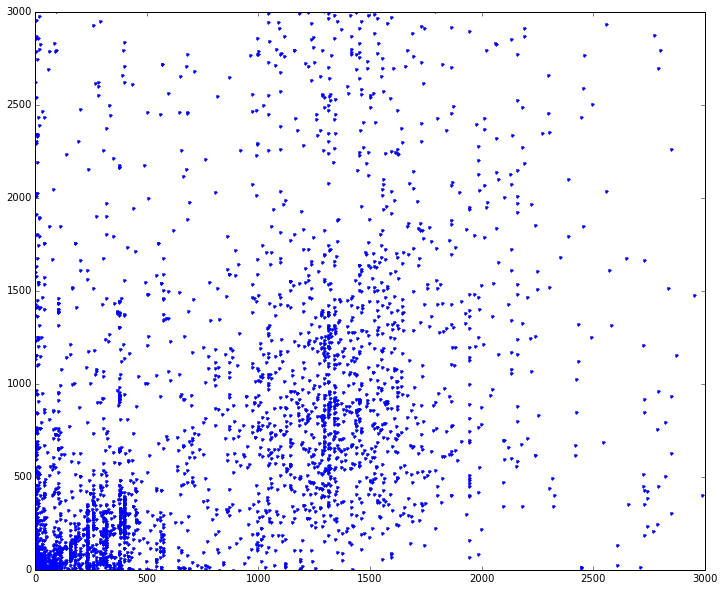

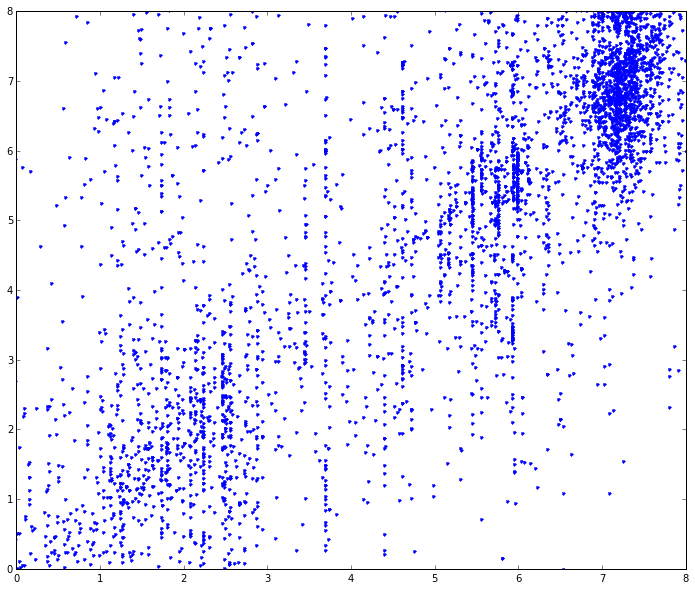

In [49]:
plt.figure()
#plt.plot(np.log(min_errors), np.log(actual_errors), '.')
plt.plot(min_errors, actual_errors, '.')
plt.axis([0,3000,0,3000])
#plt.axis([0,np.log(3000),0,np.log(3000)])

#print min(actual_errors)
from scipy.stats import pearsonr
print pearsonr(min_errors, actual_errors)
print pearsonr(np.log(min_errors), np.log(actual_errors))

plt.figure()
plt.plot(np.log(min_errors), np.log(actual_errors), '.')
plt.axis([0,np.log(3000),0,np.log(3000)])

## Same plot as above but this time containing N percent of the probability mass


Text: Flashback to freshman year with this guy since I'm excited for upgraded season tickets but sad… https://t.co/HcQLUPzCAP
User Specified Location: 
Location: [39.738412, -75.550015]
Estimated Location: (40.447719244829479, -82.688111839796974)
Error (km): 611.738464248
Percent of the world: 6.07561728395


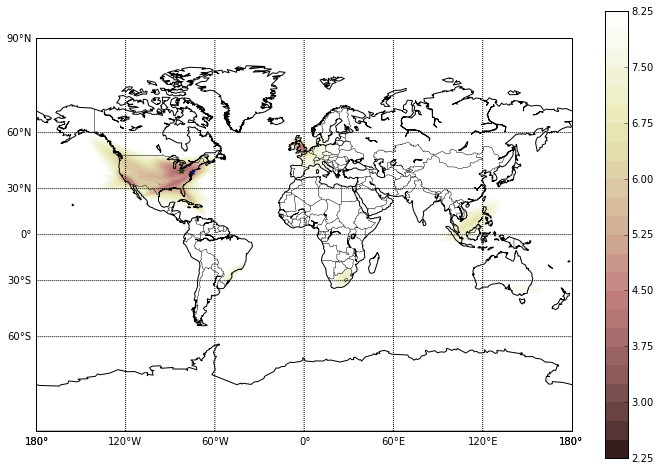

In [173]:
percent_of_mass_to_include = 0.8
tweet = local_tweets[85]
(est_location, min_error, error_distance, combined_gmm) = get_gmm_info(tweet)
print_tweet(tweet)
print 'Estimated Location:', est_location
print 'Error (km):', error_distance
plot_gmm(combined_gmm, true_ll=tweet.geo.coordinates, percent=percent_of_mass_to_include)

In [ ]:
(est_location, min_error, error_distance, gmm_model) = get_gmm_info(local_tweets[5])

In [66]:
y = np.linspace(90,-90, num=180*4)
x = np.linspace(-180,180, num=360*4)
X, Y = np.meshgrid(y,x)
XX = np.array([X.ravel(), Y.ravel()]).T
Z = np.exp(model_the[0].score_samples(XX)[0]) 

In [67]:
print Z.shape
print np.sum(Z)*.25*.25

(1036800,)
0.894770992527


In [61]:
model_the = g.model['nyc']
model_the[0].weights_

array([ 0.1741862 ,  0.02008731,  0.03349762,  0.11777219,  0.00513479,
        0.54539912,  0.00897194,  0.04464128,  0.0012837 ,  0.00673344,
        0.04229242])

In [51]:
np.sum(model_the[0].weights_)

1.0000000000000024

In [45]:
len(model_the[0].weights_)

12

In [46]:
b = model_the[0].score_samples(XX)

In [47]:
b[1].shape

(64800, 12)

In [48]:
b[1][1]

array([  3.33806894e-076,   1.72209215e-098,   0.00000000e+000,
         0.00000000e+000,   0.00000000e+000,   7.92022966e-194,
         2.34433634e-311,   6.19662874e-272,   2.56235035e-125,
         7.52975029e-014,   9.99999993e-001,   7.24556587e-009])

In [49]:
print max(b[1][1])
print sum(b[1][1])

0.999999992754
1.0


# Find probability mass for a given bouding box
####Function using KDE which approximates the area better than a simple mesh grid.  Otherwise we found that the mesh-grid could often under-sample the probability for especially 'peaky' distributions (such as nyc).

In [14]:
import statsmodels.sandbox.distributions.extras as ext
#documented at http://statsmodels.sourceforge.net/devel/_modules/statsmodels/sandbox/distributions/extras.html#mvnormcdf

In [15]:
def prob_mass(gmm_model, upper_bound, lower_bound):
    total_prob = 0
    for i in range(0, len(gmm_model.weights_)):
        val = ext.mvnormcdf(upper_bound, gmm_model.means_[i], gmm_model.covars_[i], lower_bound, maxpts=2000)
        # below is necessary as a very rare occurance causes some guassians to have a result of nan 
        #(likely exeedingly low probability)
        if math.isnan(val): 
            pass
        else:
            weighted_val = val * gmm_model.weights_[i]
            total_prob += weighted_val
    return total_prob

In [18]:
#good test is to set upper and lower limits to extent of globe and see if it approximates 1
#coordinates should go 
upper = [90,180]
lower = [-90,-180]
print prob_mass(g.model['nyc'][0], upper, lower)
print prob_mass(g.model['the'][0], upper, lower)

0.999274784039
0.998856105287


In [19]:
#mass of probability within ~10 km of the center point (0.1 degrees is 11.132 KM N/S)
gmm_model = g.model['nyc'][0]
distance = 10
distance_deg = distance/111.32
best_point = gmm_model.means_[np.argmax(gmm_model.weights_)]
print best_point, distance_deg
upper = [best_point[0]+distance_deg,best_point[1]+distance_deg]
lower = [best_point[0]-distance_deg,best_point[1]-distance_deg]
print gmm_model, upper, lower
print prob_mass(gmm_model, upper, lower)

[ 40.74756558 -73.97633181] 0.0898311174991
GMM(covariance_type='full', init_params='wmc', min_covar=0.001,
  n_components=11, n_init=1, n_iter=100, params='wmc', random_state=None,
  thresh=None, tol=0.001) [40.837396701595296, -73.886500690138774] [40.657734466597091, -74.066162925136979]
0.455953032024


In [17]:
# Compute local array of actual error and probability mass over ~100 km (which is about 62 miles)
probs = []
actual_errors = []
skipped = 0
distance = 100
distance_deg = distance/111.32
act_within = 0
cnt = 0
for i in range(0, len(local_tweets)):
    try:
        (est_location, min_error, error_distance, combined_gmm) = get_gmm_info(local_tweets[i])
        if min_error != 0 and error_distance !=0:
            best_point = combined_gmm.means_[np.argmax(combined_gmm.weights_)]
            upper = [best_point[0]+distance_deg,best_point[1]+distance_deg]
            lower = [best_point[0]-distance_deg,best_point[1]-distance_deg]
            mass = prob_mass(combined_gmm, upper, lower)
            w = np.sum(combined_gmm.weights_)
            if math.isnan(mass):
                skipped += 1
            else:
                actual_loc = local_tweets[i].geo.coordinates
                #print best_point, actual_loc, error_distance
                probs.append(mass)
                actual_errors.append(error_distance)
                cnt += 1
                #check if the actual_location is within the same 100 km box
                if (best_point[0]-distance_deg<actual_loc[0]<best_point[0]+distance_deg and
                    best_point[1]-distance_deg<actual_loc[1]<best_point[1]+distance_deg):
                    act_within +=1
    except:
        #raise
        #probs.append(0)
        #actual_errors.append(0)
        skipped += 1
correct_ratio = float(act_within)/float(cnt) *100
average_prob = np.average(probs)*100
print 'Skipped %d of %d'%(skipped, len(local_tweets))
print 'There were %d pct of tweets within radius and average probability of %f'%(correct_ratio, average_prob)

Skipped 4 of 100
There were 28 pct of tweets within radius and average probability of 30.167967


In [ ]:
radius = [25,50,75,100,125,150,200,250,300,350,400, 450, 500, 600, 700, 800, 900, 1000]
correct = []
average = []
for r in radius:
    probs = []
    actual_errors = []
    skipped = 0
    distance = r
    distance_deg = distance/111.32
    act_within = 0
    cnt = 0
    for i in range(0, len(local_tweets)):
        try:
            (est_location, min_error, error_distance, combined_gmm) = get_gmm_info(local_tweets[i])
            if min_error != 0 and error_distance !=0:
                best_point = combined_gmm.means_[np.argmax(combined_gmm.weights_)]
                upper = [best_point[0]+distance_deg,best_point[1]+distance_deg]
                lower = [best_point[0]-distance_deg,best_point[1]-distance_deg]
                mass = prob_mass(combined_gmm, upper, lower)
                w = np.sum(combined_gmm.weights_)
                if math.isnan(mass):
                    skipped += 1
                else:
                    actual_loc = local_tweets[i].geo.coordinates
                    #print best_point, actual_loc, error_distance
                    probs.append(mass)
                    actual_errors.append(error_distance)
                    cnt += 1
                    #check if the actual_location is within the same 100 km box
                    if (best_point[0]-distance_deg<actual_loc[0]<best_point[0]+distance_deg and
                        best_point[1]-distance_deg<actual_loc[1]<best_point[1]+distance_deg):
                        act_within +=1
        except:
            #raise
            #probs.append(0)
            #actual_errors.append(0)
            skipped += 1
    correct_ratio = float(act_within)/float(cnt) *100
    average_prob = np.average(probs)*100
    correct.append(correct_ratio)
    average.append(average_prob)
    #print 'Skipped %d of %d'%(skipped, len(local_tweets))
    print 'There were %f pct of tweets within %d radius and average probability of %f'%(correct_ratio, r, average_prob)

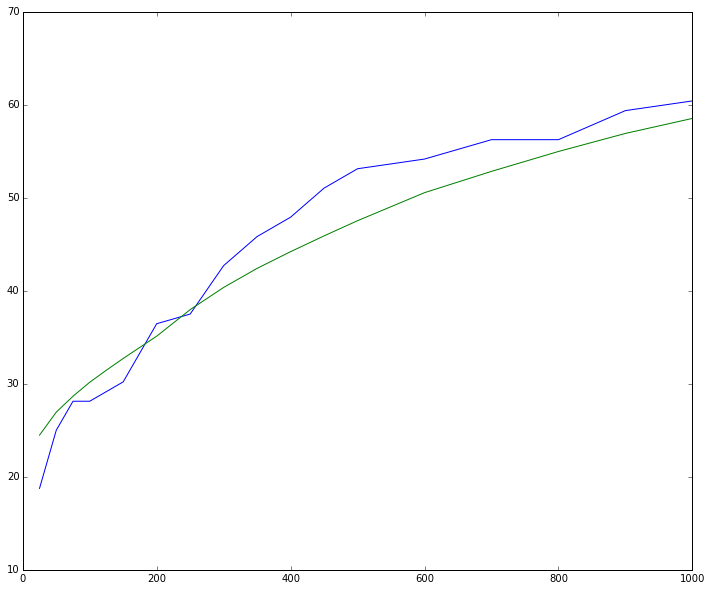

In [27]:
plt.plot(radius, correct)
plt.plot(radius, average, 'g')

In [24]:
correct

[18.75,
 25.0,
 28.125,
 28.125,
 29.166666666666668,
 30.208333333333332,
 36.45833333333333,
 37.5,
 42.70833333333333,
 45.83333333333333,
 47.91666666666667]

In [28]:
print probs
print np.average(probs)
print actual_errors

[0.33113475627100603, 0.0041094497383687128, 0.61002606656543212, 0.097722945347346643]
0.260748304481
[197.4522610848313, 8654.525962939095, 159.23825145635735, 6150.972915822179]


(-0.24286168368060004, 5.2345061223812195e-17)
(-0.6140297082497912, 6.0612602391894406e-121)


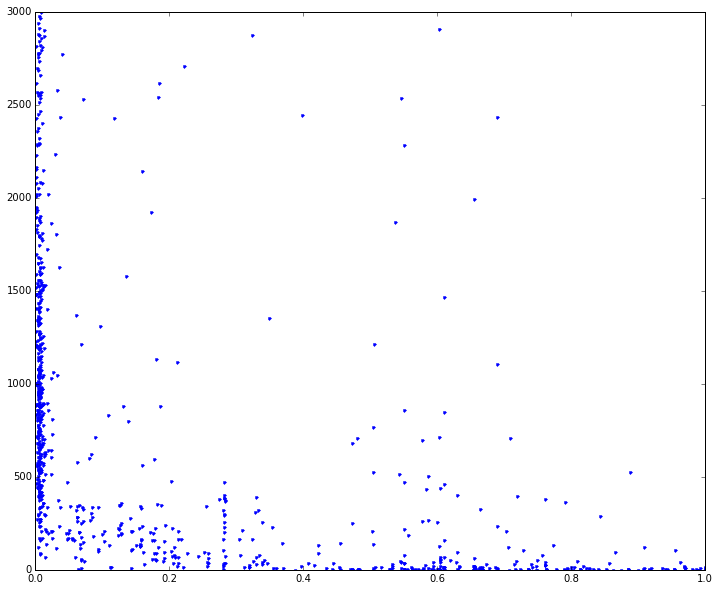

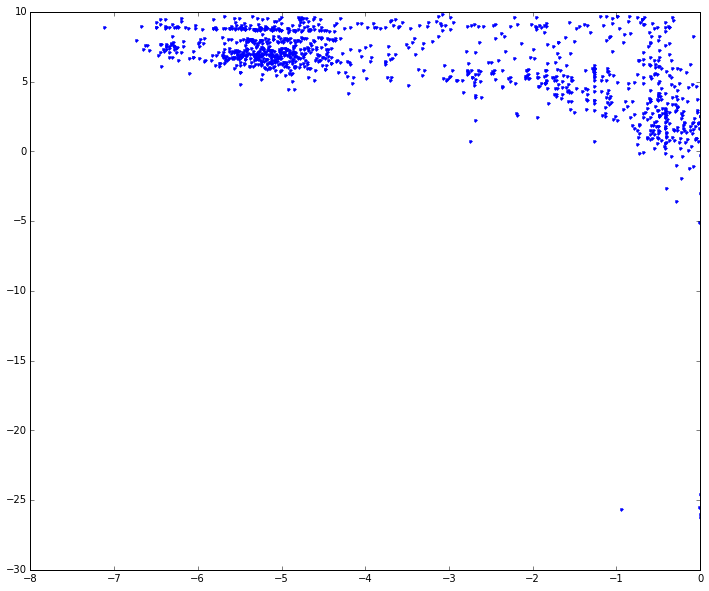

In [192]:
plt.figure()
#plt.plot(np.log(min_errors), np.log(actual_errors), '.')
plt.plot(probs, actual_errors, '.')
plt.axis([0,1,0,3000])
#plt.axis([0,np.log(3000),0,np.log(3000)])

#print min(actual_errors)
from scipy.stats import pearsonr
print pearsonr(probs, actual_errors)
print pearsonr(probs, np.log(actual_errors))

plt.figure()
plt.plot(np.log(probs), np.log(actual_errors), '.')
#plt.axis([0,np.log(.75),0,np.log(3000)])

In [193]:
print min(probs), max(probs), np.average(probs)

0.000806396782188 1.0 0.188418689332


In [194]:
(est_location, min_error, error_distance, combined_gmm) = get_gmm_info(local_tweets[85])

In [204]:
best_point = combined_gmm.means_[np.argmax(combined_gmm.weights_)]
upper = [best_point[0]+distance_deg,best_point[1]+distance_deg]
lower = [best_point[0]-distance_deg,best_point[1]-distance_deg]
mass = prob_mass(combined_gmm, upper, lower)
print mass

0.0135133049646


In [202]:
total_prob = 0
for i in range(0, len(combined_gmm.weights_)):
    val = ext.mvnormcdf(upper, combined_gmm.means_[i], combined_gmm.covars_[i], lower, maxpts=2000)
    weighted_val = val * combined_gmm.weights_[i]
    total_prob += weighted_val
    if math.isnan(val):
        print i, val, total_prob

4 nan nan


(array([ 725.,   77.,   53.,   40.,   27.,   60.,   76.,   36.,   21.,   30.]),
 array([  8.06396782e-04,   1.00725757e-01,   2.00645117e-01,
          3.00564478e-01,   4.00483838e-01,   5.00403198e-01,
          6.00322559e-01,   7.00241919e-01,   8.00161279e-01,
          9.00080640e-01,   1.00000000e+00]),
 <a list of 10 Patch objects>)

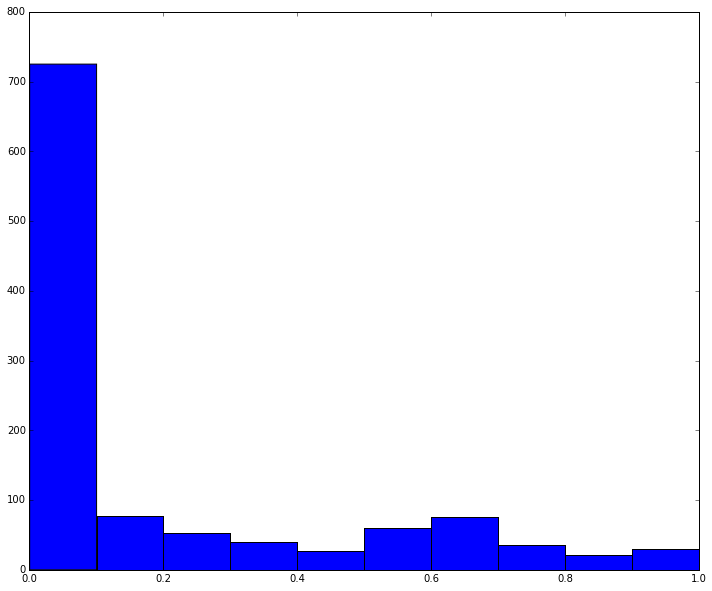

In [133]:
plt.hist(probs)